### This notebook attempts to callculate the distribution change between 2 high-res annotations

In [1]:
%run utils
import utils

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io
from tqdm import trange, tqdm
import seaborn as sns
import geopandas
from shapely.validation import make_valid
import os

In [3]:
training_both = "data/splits/training_set_naip_nlcd_both.csv"
image_number = 3716
# 3716_naip-2013
geo_json_2013 = "data/catalog/labels/data/0c85e907-3d60-415b-afa7-5fc5f16e69d0.geojson"
# 3716_naip-2017
geo_json_2017 = "data/catalog/labels/data/a4d9c2f2-c09a-4515-b061-4bb854cb4c44.geojson"

In [4]:
# read geopandas df
geo_json_2013_df = geopandas.read_file(geo_json_2013)
geo_json_2017_df = geopandas.read_file(geo_json_2017)
# reproject the original degree-based projection to Mercator
geo_json_2013_df = geo_json_2013_df.to_crs("EPSG:3395")
geo_json_2017_df = geo_json_2017_df.to_crs("EPSG:3395")

In [5]:
# labels
geo_json_2013_df['default'].unique()

array(['Impervious', 'Tree Canopy', 'Low Vegetation', 'Water'],
      dtype=object)

In [6]:
# crs
geo_json_2013_df.crs

<Derived Projected CRS: EPSG:3395>
Name: WGS 84 / World Mercator
Axis Info [cartesian]:
- E[east]: Easting (metre)
- N[north]: Northing (metre)
Area of Use:
- name: World between 80°S and 84°N.
- bounds: (-180.0, -80.0, 180.0, 84.0)
Coordinate Operation:
- name: World Mercator
- method: Mercator (variant A)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

<AxesSubplot: >

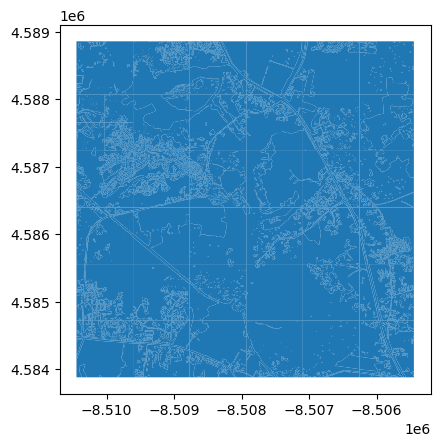

In [7]:
geo_json_2013_df.plot()

<AxesSubplot: >

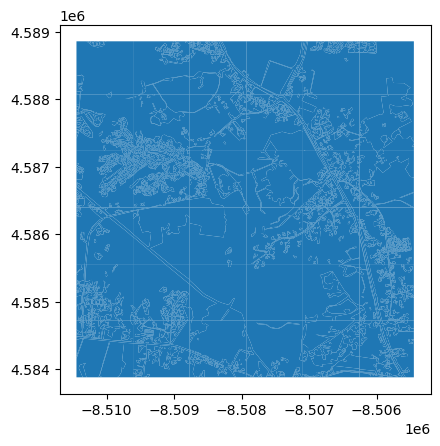

In [8]:
geo_json_2017_df.plot()

In [9]:
# add an area column
# the area should be in square meters
geo_json_2013_df['area (sq meters)'] = geo_json_2013_df.area
geo_json_2017_df['area (sq meters)'] = geo_json_2017_df.area

In [10]:
geo_json_2013_df.head(2)

,id,default,createdAt,createdBy,annotationProjectId,annotationTaskId,geometry,area (sq meters)
0,0505f576-0c2c-4078-bbac-dd0ede9ccc11,Impervious,2022-10-11 19:03:29.269000+00:00,auth0|633fb3f8b4072251152cf66e,420720bf-94c1-4f20-8aa6-6d4daa4ce762,7bbcd507-8528-4c2f-8af1-4671e5b79943,"MULTIPOLYGON (((-8510447.251 4586277.893, -851...",31774.809832
1,086cc7ca-6e98-4641-aa2a-6156bcabf956,Tree Canopy,2022-10-10 07:49:28.010000+00:00,auth0|633fb3f8b4072251152cf66e,420720bf-94c1-4f20-8aa6-6d4daa4ce762,75f79271-789a-451e-935a-e9d757dd11d8,"MULTIPOLYGON (((-8507930.673 4585554.896, -850...",550702.822286


In [11]:
# shape
print(len(geo_json_2013_df))
print(len(geo_json_2017_df))

123
115


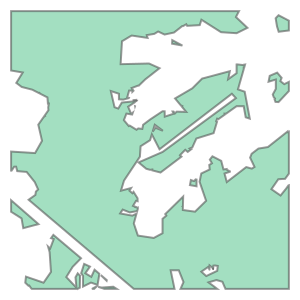

In [12]:
geo_json_2017_df.loc[0, "geometry"]

In [13]:
len(geo_json_2017_df)

115

In [14]:
geo_json_2013_df.iloc[0]

C:\Users\thefi\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\inference.py:388: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
C:\Users\thefi\anaconda3\envs\geo_env\lib\site-packages\pandas\core\dtypes\inference.py:389: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
C:\Users\thefi\anaconda3\envs\geo_env\lib\site-packages\pandas\io\formats\printing.py:117: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  s = iter(seq)
C:\Users\thefi\a

id                                  0505f576-0c2c-4078-bbac-dd0ede9ccc11
default                                                       Impervious
createdAt                               2022-10-11 19:03:29.269000+00:00
createdBy                                 auth0|633fb3f8b4072251152cf66e
annotationProjectId                 420720bf-94c1-4f20-8aa6-6d4daa4ce762
annotationTaskId                    7bbcd507-8528-4c2f-8af1-4671e5b79943
geometry               (POLYGON ((-8510447.250703596 4586277.89347549...
area (sq meters)                                            31774.809832
Name: 0, dtype: object

In [15]:
CLASSES = ['Tree Canopy', 'Low Vegetation', "Water", "Impervious"]

In [16]:
masa_annotated_3716_2013 = get_percentages("data/catalog/labels/data/0c85e907-3d60-415b-afa7-5fc5f16e69d0.geojson")
masa_annotated_3716_2017 = get_percentages("data/catalog/labels/data/a4d9c2f2-c09a-4515-b061-4bb854cb4c44.geojson")

In [17]:
def make_heatmap(geo_json_2013_df, geo_json_2017_df, annotation_2013):
    distribution_change = {k: {m: 0 for m in CLASSES} for k in CLASSES}
    for i in trange(len(geo_json_2013_df)):
        slice_2013 = geo_json_2013_df.iloc[[i]]
        class_2013 = slice_2013.iloc[0]["default"]
        area_2013 = slice_2013.iloc[0]["area (sq meters)"]
        geometry_2013 = slice_2013.iloc[0]["geometry"]
        geometry_2013 = make_valid(geometry_2013)
        intersects = geo_json_2017_df[geo_json_2017_df.intersects(geometry_2013)]
        overlayed = intersects.overlay(slice_2013, how="intersection", keep_geom_type=False)
        overlayed["Intersection Area (sq meters)"] = overlayed.area
        sum_of_changed_areas = overlayed['Intersection Area (sq meters)'].sum()
        for j in range(len(overlayed)):
            distribution_change[class_2013][overlayed.loc[j, 'default_1']] += overlayed.loc[j, 'Intersection Area (sq meters)']
    
    index_col = []
    for c in CLASSES:
        index_col.append(f"{c} ({round(annotation_2013[c] * 100, 2)}%)")
    
    # change to percentage
    for k in distribution_change.keys():
        sum_value = sum(distribution_change[k].values())
        for m in distribution_change[k].keys():
            distribution_change[k][m] /= sum_value

    # construct df by rows, make sure the order is right by 
    # iterating through CLASSES
    heatmap_df = pd.DataFrame.from_records(data=[{m: distribution_change[k][m] for m in CLASSES} for k in CLASSES], 
                                           index=index_col)
    heatmap_df = heatmap_df.round(3)

    # plot heatmap
    ax = sns.heatmap(heatmap_df, annot=True, cmap="YlGnBu")
    ax.set_title("Distribution of Changes between High-res Labels 2013 and 2016")
    ax.set_xlabel("2016 Class")
    ax.set_ylabel("2013 Class")
    plt.savefig(f"Distribution of Changes between High-res Labels 2013 and 2016 (using geopandas).png", bbox_inches='tight')

  4%|█████▌                                                                                                                                    | 5/123 [00:00<00:17,  6.62it/s]C:\Users\thefi\anaconda3\envs\geo_env\lib\site-packages\geopandas\tools\overlay.py:299: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[mask, col] = df.loc[mask, col].buffer(0)
 45%|█████████████████████████████████████████████████████████████▎                                                                           | 55/123 [00:05<00:05, 11.80it/s]C:\Users\thefi\anaconda3\envs\geo_env\lib\site-packages\geopandas\tools\overlay.py:299: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old 

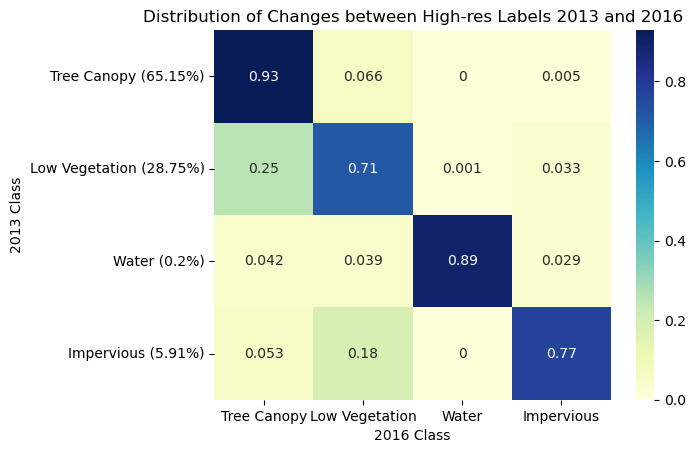

In [18]:
make_heatmap(geo_json_2013_df, geo_json_2017_df, masa_annotated_3716_2013)